<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time-series forecasting with TensorFlow

What are we going to cover?
1. Get a time series data (the historical price of Bitcoin)
  * Load time series data using Pandas/Python CSV
2. Format data for a time series problem
  * Creating a training and test set wrong way
  * Creating a training and test set right way
  * Visualizing time series data
  * Turning time series model into supervised learning problem ( Windowing )
  * Preparing Univariate and Multivariable ( more than one variable ) data

3. Evaluating a time series model
4. Setting up a series for deep leaning modelling experiments
  * Dense fully connected
  * Sequence model ( LSTM and 1D CNN )
  * Ensembling ( combining multiple models together )
  * Multivariate models
  * Replicating the N-Beats algorithm using Tensorflow Layer subclassing
5. Creating a modelling checkpoint to save best performing model
6. Making predictions (forecast) with time series model.
7. Creating prediction intervals for time series forecasts.


## 1. Get the data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-28 01:13:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-07-28 01:13:06 (6.87 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



### 1.1 Import time series data with Pandas

In [2]:
import pandas as pd
price_df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
                 ,parse_dates=["Date"]
                 ,index_col=["Date"]
                 )

price_df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
len(price_df)

2787

🔑note: The frequency at which time series data is collected is often referred to as **seasonality**. Seasonality is often measured as number of samples / year.

In [5]:
# We only want the closing price
daily_price_df = pd.DataFrame(price_df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
daily_price_df.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


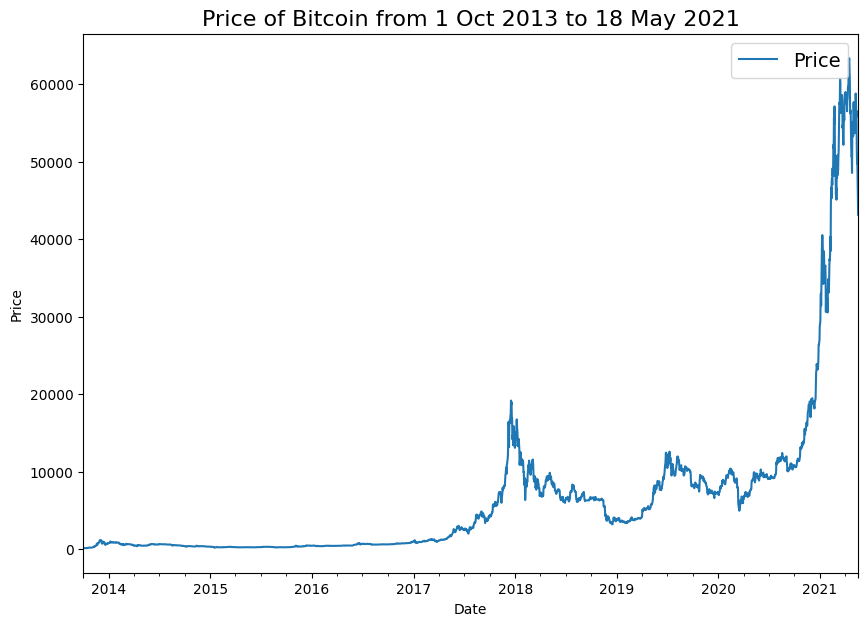

In [6]:
import matplotlib.pyplot as plt
daily_price_df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## 2. Creating the training and test set
### 2.1 The wrong way

In [7]:
# Convert our dataframe index and columns to numpy arrays
timesteps = daily_price_df.index.to_numpy()
prices = daily_price_df["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(timesteps
                                                   ,prices
                                                   ,test_size=0.2
                                                   ,random_state=42)
len(X_train),len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

### 2.2 Let's visualize the splits

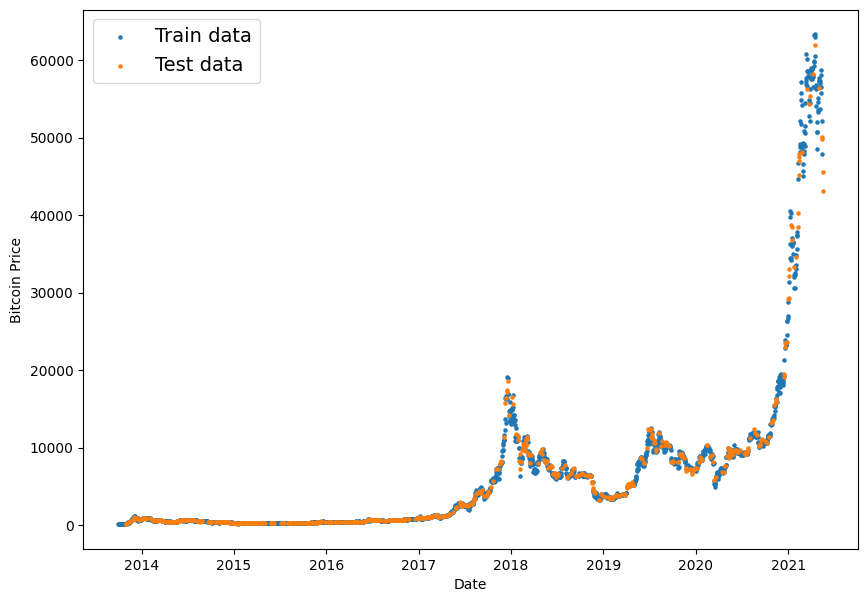

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

As we can see in the above plot our test data is scattered across the training data. This kind of random split works great with data where there is no temporal (time) component. But when time component is invovled, we need to split the data in such a way that it should reflect our purpose. The purpose here is to analyze the historical price and predict or forecast the future price.

### 2.3 Creating the train test split the right way

In [10]:
split_size = int(0.8* len(prices))

X_train,y_train = timesteps[:split_size],prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

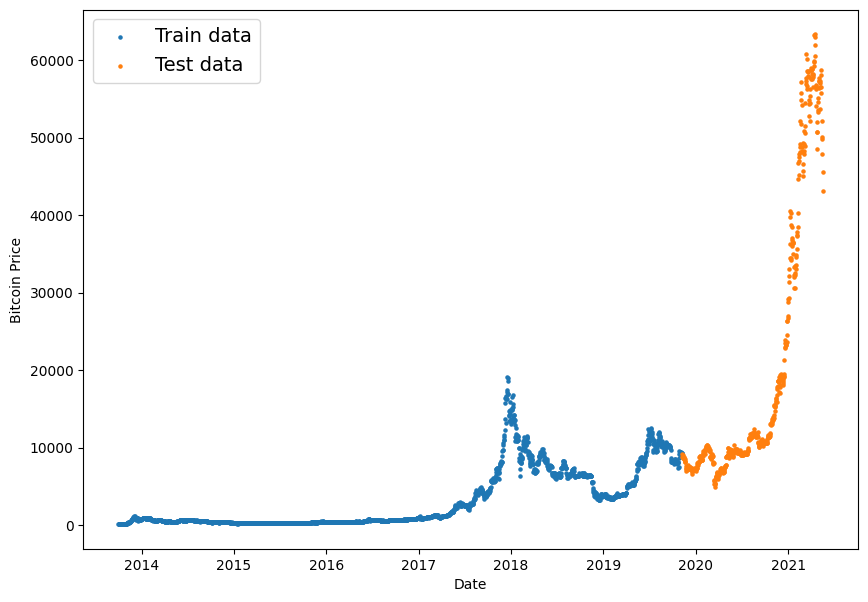

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

## Model 0: Navive Forecast ( baseline )
As usual lets start with a baseline.
One of the most common baseline for time series forecasting, the naive model requires no training.
That's because all that the naive model does is forecast the next timestep value based on previous timestep value.
The formula looks like:

̂y<sub>t</sub> = y<sub>t</sub> -1

In [12]:
# create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10],naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [13]:
# Create a plotting function

def plot_time_series(timesteps,values,format='.', start=0, end=None, label=None):
  """
    Plots a timesteps (a series of points in time) against values ( a series of values across timesteps)

    Parameters
    -------------
    timesteps: array of timesteps
    values: array of values across time
    format: style of plot, default "."
    start: where to start the plot ( setting a value will index from start of timesteps and values)
    end: where to end the plot (setting a value will index from end of timesteps & values )
    label: label to show on plot of values
  """
  ## Plot the series
  plt.plot(timesteps[start:end],values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

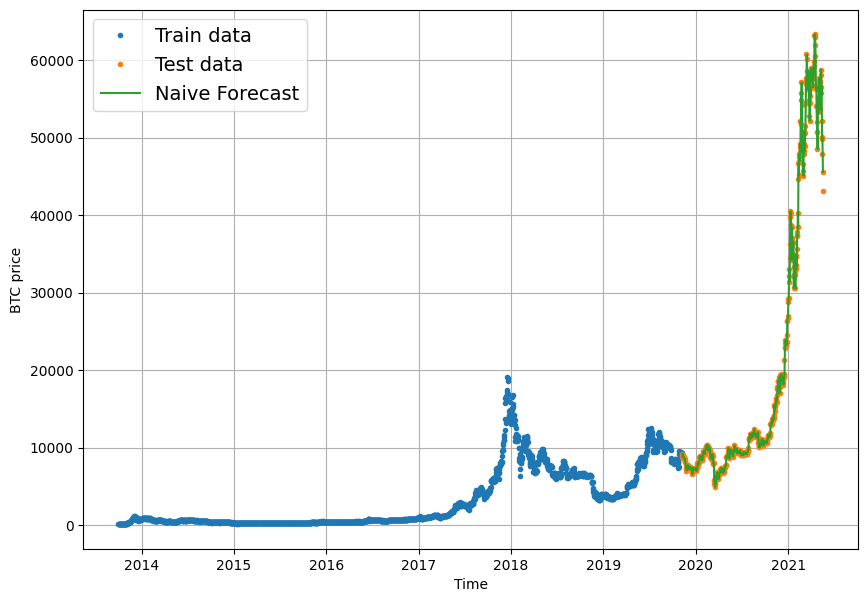

In [14]:
# Plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train data")
plot_time_series(timesteps=X_test,values=y_test,label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive Forecast")

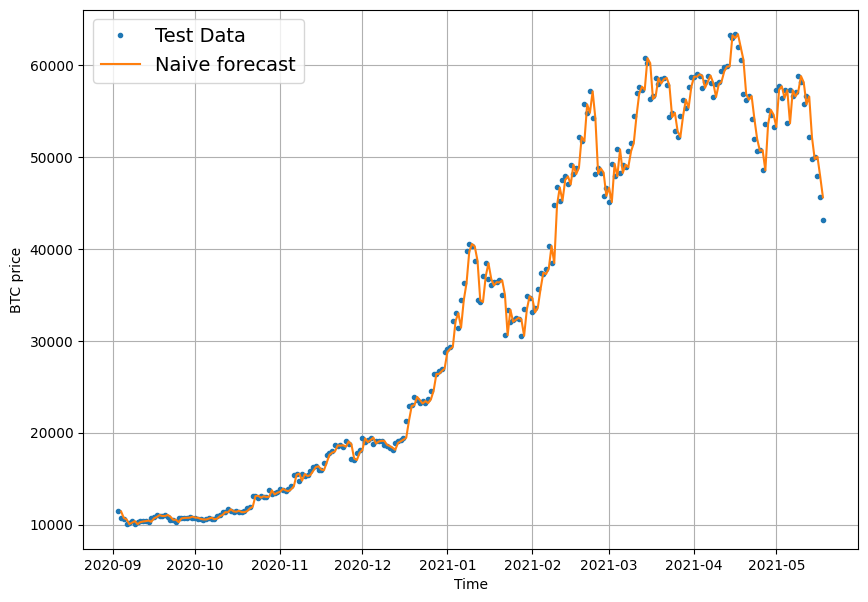

In [15]:
plt.figure(figsize=(10,7))
offset = 300
plot_time_series(timesteps=X_test,values=y_test, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast, format="-", start=offset, label="Naive forecast")

## Evaluate a time series model
Time series forecasting often involves predicting a number.
As the problem statement is about predicting a number, it comes under **regression**
For all the following metrics **lower is better** ( for e.g MAE 0 is better than MAE 100)

### Scale-depdendent errors
These are metrics which can be used to compare time series values and forecast that are on the same scale

Metrics| Details|Code
---|---|---
MAE ( Mean Absolute Error ) | Easy to interpret. Forecast methods which minimizes the <br> MAE will lead to forecasts of the median |`tf.keras.metrics.mean_absolute_error()`
RMSE(Root Mean Squared Error ) | Forecast which minimizes the RMSE lead to forecasts <br> to the mean| `tf.keras.metrics.mean_squared_error()`

### Percentage Errors
Percentage errors do not have units, which mean they can be used to compare forecasts across different units.

Metrics|Details|Code
---|---|---
**MAPE**(Mean Absolute Percentage Error)|Most commonly used percentage error|`tf.keras.metrics.mean_absolute_percentage_error`
**sMAPE**(symmetric Mean Absolute Percentage Error)| Recommend not to use|Custom implementation

### Scaled Errors
Scaled errors are alternative to percentage errors when comparing forecasting performance across different timeseries

Metrics|Details|Code
---|---|---
MASE(mean absolute scaled error)|A forecast which performs better than naive should get <1 MASE|See sktimes<br> `mase_loss()`


In [16]:
import tensorflow as tf


In [17]:
# MASE implemented
def mean_absolute_scaled_error(y_true, y_pred):
  """
    Implement MASE ( assuming no seasonality data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  ## find MAE for naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1]))

  return mae/mae_naive_no_season

> In practice the naive model should achieve an MASE of 1 (or very close to 1). Any model worse than the naive forecast will achieve an MASE of > 1 and any model better than naive forecast will achieve and MASE of < 1

Let's put each of our different evaluation metrics together into a function

In [18]:
def evaluate_pred(y_true,y_pred):
  #Make sure float32 ( for metric calculation)
  y_true= tf.cast(y_true,dtype=tf.float32)
  y_pred= tf.cast(y_pred,dtype=tf.float32)

  # Calculate various metrics
  mae= tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse= tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse= tf.sqrt(mse)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase= mean_absolute_scaled_error(y_true,y_pred)

  return {
      "mae": mae.numpy()
      ,"mse": mse.numpy()
      ,"rmse": rmse.numpy()
      ,"mape": mape.numpy()
      ,"mase": mase.numpy()
  }

In [19]:
naive_results= evaluate_pred(y_true=y_test[1:]
                             ,y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Looking at the MAE results, we can infer that on an average the predicted bitcoin price is off from the actual price by about ~567 USD.

## Format Data Part2: Windowing dataset
**Windowing** is a method to turn a time series dataset to _supervised learning problem_.
In other words, we want to use windows of the past to predict the future.
For example, for a univariate time series, windowing for one week(`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

Let's write a function that can take a univariate time series and turn into windows and horizon of specified sizes.

We'll start the default horizon size of 1 and window size of 7


In [20]:
HORIZON= 1 # predict 1 timestep at a time
WINDOW_SIZE= 7 #use a week worth of timesteps to predict the horizon

Now we will write a function that will take an array and return a window and horizon


In [21]:
# Create a function to create labelled window data
def get_labelled_windows(x,horizon=1):
  """
    Creates a label for window dataset
    E.g if horizon=1 (default)
    Input: [1,2,3,4,5,6] -> Output ([1,2,3,4,5],[6])
  """
  return (x[:,:-horizon],x[:, -horizon:])

In [22]:
# Test the window labelling function
test_window, test_label= get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0),horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


#### Make window for the entire timeseries
Let's write a function which:
1. Create a window step of specific window size, for example `[[0,1,2,3,4,5,6]]`
2. Uses [Numpy Indexing]() to create a 2D of multiple window steps, for example
```
[[0,1,2,3,4,5,6,7]
 [1,2,3,4,5,6,7,8]
 [2,3,4,5,6,7,8,9]]
```
3. Uses the 2D array of multiple window steps to index to a target series.
4. Uses the `get_labelled_window` function we created above to turn the window steps into windows with a specified horizon.

In [23]:
import numpy as np

In [24]:
# Create a function to view Numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
   Turns a 1D array into a 2D array of sequential windows of a given window size.
  """
  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step= np.expand_dims(np.arange(window_size+horizon),axis=0)
  # 2. Create a 2D array of multiple window steps
  window_indexes= window_step+ np.expand_dims(np.arange(len(x)- (window_size+horizon-1)),axis=0).T
  # 3. Index on the target array with 2D array of multiple window steps
  windowed_array= x[window_indexes]
  # 4. Get the labelled windows
  windows, labels= get_labelled_windows(windowed_array,horizon=horizon)
  return windows,labels

In [25]:
np.expand_dims(np.arange(7+1),0).T

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]])

In [26]:
full_windows, full_labels= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [27]:
## view the first 3 windows/labels
for i in range(3):
  print(f" Window: {full_windows[i]}, Label: {full_labels[i]}")

 Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], Label: [123.033]
 Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], Label: [124.049]
 Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], Label: [125.96116]


We can use tensorflow inbuilt functions to achieve the same output. We need to use `tf.keras.preprocessing.timeseries_dataset_from_array()`

TODO: We will look into this later.

### Turning windows into training and test set
Let's write a function that takes a full set of windows and their labels and splits them into train & test splits.

In [28]:
# Make the train/test split
def make_train_test_split(windows,labels,test_split=0.2):
  """
    Splits matching pairs of windows and labels into train and test split.

  """
  split_size= int(len(windows) * (1-test_split))

  train_windows= windows[:split_size]
  train_labels= labels[:split_size]
  test_windows= windows[split_size:]
  test_labels= labels[split_size:]

  return train_windows, train_labels, test_windows,test_labels


In [29]:
train_windows, train_labels, test_windows,test_labels = make_train_test_split(full_windows,full_labels)
len(train_windows), len(test_windows),  len(train_labels),len(test_labels)


(2224, 556, 2224, 556)

In [30]:
train_windows[:5],train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Making a model checkpoint
The `ModelCheckpoint` callback will monitor our model performance during the training and saves the best model to the file system by setting `save_best_only=True`

In [31]:
import os
# create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name,save_path="model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name)
                                            ,verbose=0
                                            ,save_best_only=True)

## Model 1: Dense Model ( window = 7, horizon = 1)
Time to build one of our models

`model_1` will have:
* A single dense layer with 128 hidden units and ReLU activation unit.
* An output layer with linear activation.
* Adam optimizer with MAE loss
* Batch size of 128
* 100 epochs

In [32]:
import tensorflow as tf
from tensorflow.keras import layers

## set seed
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation=tf.keras.activations.relu)
    ,layers.Dense(HORIZON,activation=tf.keras.activations.linear)
],name="model_1_dense")

model_1.compile(loss=tf.keras.losses.mean_absolute_error
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"]
                )

history_1= model_1.fit(x=train_windows
                       ,y=train_labels
                       ,epochs=100
                       ,verbose=1
                       ,batch_size=128
                       ,validation_data=(test_windows,test_labels)
                       ,callbacks=[create_model_checkpoint(model_name=model_1.name)]
                       )



Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 3760.9497 - mae: 3760.9497 

18/18 [==============================] - 5s 119ms/step - loss: 3643.4731 - mae: 3643.4731 - val_loss: 10991.2881 - val_mae: 10991.2881
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 692.7611 - mae: 692.7611  

18/18 [==============================] - 1s 80ms/step - loss: 675.6666 - mae: 675.6666 - val_loss: 2824.3130 - val_mae: 2824.3130
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 293.2098 - mae: 293.2098

18/18 [==============================] - 2s 100ms/step - loss: 279.8727 - mae: 279.8727 - val_loss: 1075.7711 - val_mae: 1075.7711
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 213.7626 - mae: 213.7626 - val_loss: 1091.4623 - val_mae: 1091.4623
Epoch 5/100
13/18 [====================>.........] - ETA: 0s - loss: 194.9794 - mae: 194.9794

18/18 [==============================] - 1s 83ms/step - loss: 190.0092 - mae: 190.0092 - val_loss: 1031.4211 - val_mae: 1031.4211
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 193.1897 - mae: 193.1897 - val_loss: 1065.2415 - val_mae: 1065.2415
Epoch 7/100
 9/18 [==============>...............] - ETA: 0s - loss: 205.3138 - mae: 205.3138

18/18 [==============================] - 2s 98ms/step - loss: 187.8944 - mae: 187.8944 - val_loss: 994.7417 - val_mae: 994.7417
Epoch 8/100
15/18 [========================>.....] - ETA: 0s - loss: 176.3529 - mae: 176.3529

18/18 [==============================] - 1s 83ms/step - loss: 177.8166 - mae: 177.8166 - val_loss: 990.4586 - val_mae: 990.4586
Epoch 9/100
13/18 [====================>.........] - ETA: 0s - loss: 169.9331 - mae: 169.9331

18/18 [==============================] - 3s 163ms/step - loss: 172.2030 - mae: 172.2030 - val_loss: 965.4813 - val_mae: 965.4813
Epoch 10/100
 6/18 [=========>....................] - ETA: 0s - loss: 156.7588 - mae: 156.7588

18/18 [==============================] - 2s 129ms/step - loss: 169.4981 - mae: 169.4981 - val_loss: 932.0468 - val_mae: 932.0468
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 165.6375 - mae: 165.6375

18/18 [==============================] - 2s 117ms/step - loss: 164.8774 - mae: 164.8774 - val_loss: 906.9086 - val_mae: 906.9086
Epoch 12/100
18/18 [==============================] - 0s 9ms/step - loss: 162.2823 - mae: 162.2823 - val_loss: 1007.5922 - val_mae: 1007.5922
Epoch 13/100
17/18 [===========================>..] - ETA: 0s - loss: 161.0530 - mae: 161.0530

18/18 [==============================] - 1s 78ms/step - loss: 160.4025 - mae: 160.4025 - val_loss: 894.8569 - val_mae: 894.8569
Epoch 14/100
14/18 [======================>.......] - ETA: 0s - loss: 157.4944 - mae: 157.4944

18/18 [==============================] - 2s 93ms/step - loss: 154.9603 - mae: 154.9603 - val_loss: 858.5364 - val_mae: 858.5364
Epoch 15/100
18/18 [==============================] - 0s 16ms/step - loss: 157.2473 - mae: 157.2473 - val_loss: 907.5568 - val_mae: 907.5568
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 144.9244 - mae: 144.9244

18/18 [==============================] - 1s 35ms/step - loss: 146.4574 - mae: 146.4574 - val_loss: 798.0084 - val_mae: 798.0084
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 135.4276 - mae: 135.4276

18/18 [==============================] - 1s 38ms/step - loss: 138.0505 - mae: 138.0505 - val_loss: 786.7658 - val_mae: 786.7658
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 140.6827 - mae: 140.6827

18/18 [==============================] - 1s 37ms/step - loss: 133.2870 - mae: 133.2870 - val_loss: 767.3256 - val_mae: 767.3256
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 77.8772 - mae: 77.8772

18/18 [==============================] - 1s 41ms/step - loss: 130.5848 - mae: 130.5848 - val_loss: 751.5712 - val_mae: 751.5712
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 131.5175 - mae: 131.5175

18/18 [==============================] - 1s 59ms/step - loss: 133.3627 - mae: 133.3627 - val_loss: 702.8932 - val_mae: 702.8932
Epoch 21/100
18/18 [==============================] - ETA: 0s - loss: 130.3127 - mae: 130.3127

18/18 [==============================] - 1s 58ms/step - loss: 130.3127 - mae: 130.3127 - val_loss: 684.0228 - val_mae: 684.0228
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 171.7647 - mae: 171.7647

18/18 [==============================] - 1s 43ms/step - loss: 126.1156 - mae: 126.1156 - val_loss: 678.8022 - val_mae: 678.8022
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 144.6783 - mae: 144.6783

18/18 [==============================] - 1s 37ms/step - loss: 123.4351 - mae: 123.4351 - val_loss: 668.5479 - val_mae: 668.5479
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 133.4687 - mae: 133.4687

18/18 [==============================] - 1s 36ms/step - loss: 120.4376 - mae: 120.4376 - val_loss: 652.3776 - val_mae: 652.3776
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 125.6716 - mae: 125.6716

18/18 [==============================] - 1s 35ms/step - loss: 120.8069 - mae: 120.8069 - val_loss: 646.7106 - val_mae: 646.7106
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 120.0478 - mae: 120.0478 - val_loss: 646.8646 - val_mae: 646.8646
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 174.4524 - mae: 174.4524

18/18 [==============================] - 1s 37ms/step - loss: 119.5380 - mae: 119.5380 - val_loss: 630.9027 - val_mae: 630.9027
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 111.8058 - mae: 111.8058

18/18 [==============================] - 1s 36ms/step - loss: 116.6707 - mae: 116.6707 - val_loss: 630.4778 - val_mae: 630.4778
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 116.6650 - mae: 116.6650

18/18 [==============================] - 1s 59ms/step - loss: 115.2911 - mae: 115.2911 - val_loss: 627.0209 - val_mae: 627.0209
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 118.3332 - mae: 118.3332 - val_loss: 634.5627 - val_mae: 634.5627
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 120.6072 - mae: 120.6072 - val_loss: 691.8295 - val_mae: 691.8295
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 120.3050 - mae: 120.3050

18/18 [==============================] - 1s 38ms/step - loss: 116.1838 - mae: 116.1838 - val_loss: 612.1895 - val_mae: 612.1895
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7281 - mae: 115.7281 - val_loss: 621.9442 - val_mae: 621.9442
Epoch 34/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7081 - mae: 115.7081 - val_loss: 616.8978 - val_mae: 616.8978
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 97.4972 - mae: 97.4972

18/18 [==============================] - 1s 36ms/step - loss: 114.7543 - mae: 114.7543 - val_loss: 608.0326 - val_mae: 608.0326
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 121.5786 - mae: 121.5786 - val_loss: 659.8100 - val_mae: 659.8100
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 148.1203 - mae: 148.1203

18/18 [==============================] - 1s 36ms/step - loss: 114.1101 - mae: 114.1101 - val_loss: 600.3483 - val_mae: 600.3483
Epoch 38/100
18/18 [==============================] - 0s 4ms/step - loss: 113.1274 - mae: 113.1274 - val_loss: 613.5735 - val_mae: 613.5735
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 115.6203 - mae: 115.6203 - val_loss: 638.8630 - val_mae: 638.8630
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 106.2203 - mae: 106.2203

18/18 [==============================] - 1s 36ms/step - loss: 111.6037 - mae: 111.6037 - val_loss: 595.3126 - val_mae: 595.3126
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 111.9128 - mae: 111.9128 - val_loss: 611.8822 - val_mae: 611.8822
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0546 - mae: 115.0546 - val_loss: 612.4564 - val_mae: 612.4564
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0539 - mae: 113.0539 - val_loss: 598.9610 - val_mae: 598.9610
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9596 - mae: 113.9596 - val_loss: 595.7664 - val_mae: 595.7664
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 112.0025 - mae: 112.0025 - val_loss: 609.2155 - val_mae: 609.2155
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 84.1321 - mae: 84.1321

18/18 [==============================] - 1s 37ms/step - loss: 111.8446 - mae: 111.8446 - val_loss: 591.3845 - val_mae: 591.3845
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6923 - mae: 110.6923 - val_loss: 612.9393 - val_mae: 612.9393
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 110.1275 - mae: 110.1275 - val_loss: 612.7234 - val_mae: 612.7234
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 162.6488 - mae: 162.6488

18/18 [==============================] - 1s 53ms/step - loss: 115.9278 - mae: 115.9278 - val_loss: 583.8930 - val_mae: 583.8930
Epoch 50/100
18/18 [==============================] - 0s 17ms/step - loss: 110.8006 - mae: 110.8006 - val_loss: 623.2976 - val_mae: 623.2976
Epoch 51/100
18/18 [==============================] - 0s 13ms/step - loss: 110.8177 - mae: 110.8177 - val_loss: 592.0732 - val_mae: 592.0732
Epoch 52/100
18/18 [==============================] - 0s 9ms/step - loss: 112.2189 - mae: 112.2189 - val_loss: 598.8688 - val_mae: 598.8688
Epoch 53/100
18/18 [==============================] - 0s 16ms/step - loss: 114.1588 - mae: 114.1588 - val_loss: 605.3142 - val_mae: 605.3142
Epoch 54/100
18/18 [==============================] - 0s 20ms/step - loss: 114.4697 - mae: 114.4697 - val_loss: 607.0651 - val_mae: 607.0651
Epoch 55/100
16/18 [=========================>....] - ETA: 0s - loss: 114.7456 - mae: 114.7456

18/18 [==============================] - 2s 131ms/step - loss: 111.4055 - mae: 111.4055 - val_loss: 583.4327 - val_mae: 583.4327
Epoch 56/100
18/18 [==============================] - 0s 10ms/step - loss: 111.1867 - mae: 111.1867 - val_loss: 844.6569 - val_mae: 844.6569
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 136.6455 - mae: 136.6455 - val_loss: 685.3148 - val_mae: 685.3148
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 120.6733 - mae: 120.6733 - val_loss: 662.8568 - val_mae: 662.8568
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0814 - mae: 113.0814 - val_loss: 604.8898 - val_mae: 604.8898
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 111.9931 - mae: 111.9931 - val_loss: 640.0500 - val_mae: 640.0500
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 110.1543 - mae: 110.1543 - val_loss: 586.2827 - val_mae: 586.2827
Epoch 62/100
18/18 [==========

18/18 [==============================] - 1s 39ms/step - loss: 113.0455 - mae: 113.0455 - val_loss: 573.6863 - val_mae: 573.6863
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 114.1401 - mae: 114.1401

18/18 [==============================] - 1s 40ms/step - loss: 109.9271 - mae: 109.9271 - val_loss: 573.1182 - val_mae: 573.1182
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 108.6749 - mae: 108.6749 - val_loss: 618.8995 - val_mae: 618.8995
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 115.2886 - mae: 115.2886 - val_loss: 696.8459 - val_mae: 696.8459
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 127.5794 - mae: 127.5794 - val_loss: 725.6473 - val_mae: 725.6473
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 122.3290 - mae: 122.3290 - val_loss: 578.2622 - val_mae: 578.2622
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 111.0412 - mae: 111.0412 - val_loss: 580.0414 - val_mae: 580.0414
Epoch 72/100
18/18 [==============================] - ETA: 0s - loss: 109.1762 - mae: 109.1762

18/18 [==============================] - 1s 42ms/step - loss: 109.1762 - mae: 109.1762 - val_loss: 570.5995 - val_mae: 570.5995
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 111.0013 - mae: 111.0013 - val_loss: 656.1019 - val_mae: 656.1019
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 107.8853 - mae: 107.8853 - val_loss: 571.9374 - val_mae: 571.9374
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 108.2382 - mae: 108.2382 - val_loss: 582.6360 - val_mae: 582.6360
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 109.9253 - mae: 109.9253 - val_loss: 577.8062 - val_mae: 577.8062
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 106.7971 - mae: 106.7971 - val_loss: 577.9468 - val_mae: 577.9468
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 111.5913 - mae: 111.5913 - val_loss: 578.7133 - val_mae: 578.7133
Epoch 79/100
18/18 [============

18/18 [==============================] - 1s 38ms/step - loss: 107.4335 - mae: 107.4335 - val_loss: 567.6978 - val_mae: 567.6978
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9276 - mae: 113.9276 - val_loss: 577.1741 - val_mae: 577.1741
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 113.1695 - mae: 113.1695 - val_loss: 650.1970 - val_mae: 650.1970
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9588 - mae: 113.9588 - val_loss: 581.6180 - val_mae: 581.6180
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 107.3078 - mae: 107.3078 - val_loss: 578.0323 - val_mae: 578.0323
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1579 - mae: 109.1579 - val_loss: 602.8190 - val_mae: 602.8190
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 106.7088 - mae: 106.7088 - val_loss: 591.8712 - val_mae: 591.8712
Epoch 88/100
18/18 [============

18/18 [==============================] - 1s 38ms/step - loss: 107.3024 - mae: 107.3024 - val_loss: 564.7151 - val_mae: 564.7151
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 106.6814 - mae: 106.6814 - val_loss: 591.4382 - val_mae: 591.4382
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 110.1060 - mae: 110.1060 - val_loss: 588.3875 - val_mae: 588.3875
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7816 - mae: 109.7816 - val_loss: 564.8751 - val_mae: 564.8751
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7944 - mae: 113.7944 - val_loss: 600.0532 - val_mae: 600.0532
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 110.8633 - mae: 110.8633 - val_loss: 587.1409 - val_mae: 587.1409
Epoch 95/100
 1/18 [>.............................] - ETA: 0s - loss: 138.9773 - mae: 138.9773

18/18 [==============================] - 1s 38ms/step - loss: 106.6430 - mae: 106.6430 - val_loss: 562.9643 - val_mae: 562.9643
Epoch 96/100
18/18 [==============================] - 0s 4ms/step - loss: 110.1579 - mae: 110.1579 - val_loss: 644.3585 - val_mae: 644.3585
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 109.9149 - mae: 109.9149 - val_loss: 609.9517 - val_mae: 609.9517
Epoch 98/100
18/18 [==============================] - 0s 4ms/step - loss: 109.6186 - mae: 109.6186 - val_loss: 592.6377 - val_mae: 592.6377
Epoch 99/100
18/18 [==============================] - 0s 4ms/step - loss: 109.5641 - mae: 109.5641 - val_loss: 576.5713 - val_mae: 576.5713
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 117.9937 - mae: 117.9937 - val_loss: 650.4100 - val_mae: 650.4100


In [33]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 650.4100 - mae: 650.4100


[650.4099731445312, 650.4099731445312]

In [34]:
# Load in best saved model and evaluate on test data
saved_model_1 = tf.keras.models.load_model("model_experiment/model_1_dense")
saved_model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 562.9643 - mae: 562.9643


[562.9642944335938, 562.9642944335938]

## Making forecast with a model ( on test dataset )
Since we are going to run more modelling experiments, lets write a function which can return the predictions given a model and input data

* Take a trained model
* Take in some input data
* Pass the input data to the model
* Returns the prediction

In [35]:
def make_preds(model,input_data):
  """
    Uses model to make predictions on input data

    Args:
      model: trained model
      input_data: windowed input data ( same kind as the model is trained on)
    Returns:
      model prediction on input data
  """
  return tf.squeeze(model.predict(input_data))

In [36]:
model_1_preds = make_preds(model_1,test_windows)
model_1_preds[:10], len(model_1_preds)

18/18 [==============================] - 0s 1ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8716.169, 8634.791, 8869.333, 8637.431, 8618.751, 8608.79 ,
        8521.302, 8392.017, 8330.122, 8379.357], dtype=float32)>,
 556)

### Now lets evaluate our model using the `evaluate_model` method we create above in this notebook

In [37]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [38]:
evaluate_pred?

In [39]:
model_1_results = evaluate_pred(y_true=tf.squeeze(test_labels)
                                ,y_pred=model_1_preds)
model_1_results

{'mae': 650.41,
 'mse': 1330815.1,
 'rmse': 1153.6096,
 'mape': 2.983493,
 'mase': 1.1425902}

### Let us use the `plot_time_series` function to plot the `model_1_preds` against the test_data

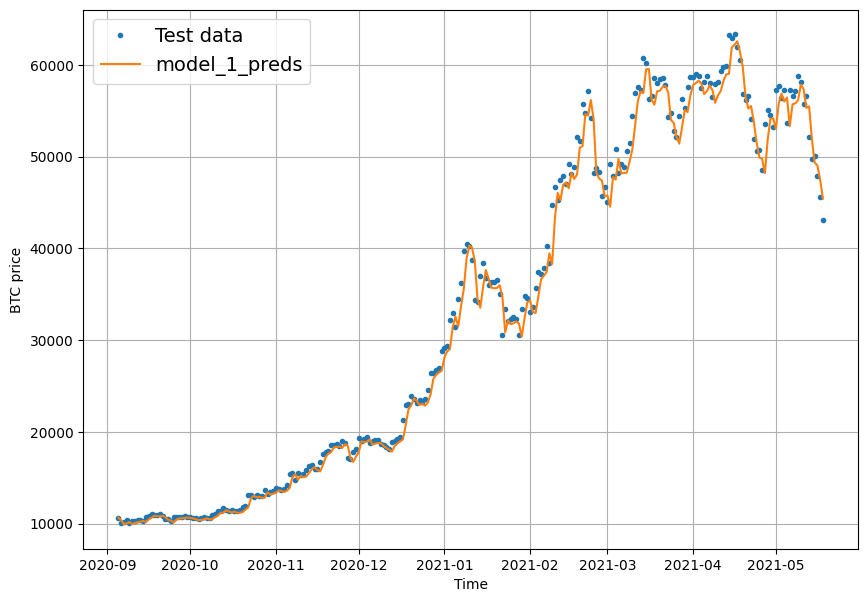

In [40]:
offset= 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0]
                 ,start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds
                 ,start=offset,label="model_1_preds",format="-")


## Model 2: Window size=30, Horizon=1
We will start with our second modelling experiment where the window size=30 and horizon=1

We will use the functions we have created earlier to create our train/test feature and train/test labels


In [41]:
HORIZON=1
WINDOW_SIZE=30

In [42]:
full_windows, full_labels = make_windows(prices,window_size=WINDOW_SIZE
                                         ,horizon=HORIZON)

len(full_windows), len(full_labels)

(2757, 2757)

In [43]:
train_window, train_label, test_window , test_label=make_train_test_split(full_windows
                                                                         ,full_labels
                                                                         ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)


(2205, 2205, 552, 552)

In [44]:
import tensorflow as tf
from tensorflow.keras import layers

# set seed
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_2_Dense")

model_2.compile(loss="mae"
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["mae"]
                 )
history_2 = model_2.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_2.name)])





Epoch 1/100
66/69 [===========================>..] - ETA: 0s - loss: 378.1536 - mae: 378.1536

69/69 [==============================] - 3s 22ms/step - loss: 373.3441 - mae: 373.3441 - val_loss: 1312.9489 - val_mae: 1312.9489
Epoch 2/100
69/69 [==============================] - 0s 3ms/step - loss: 232.6907 - mae: 232.6907 - val_loss: 1783.4873 - val_mae: 1783.4873
Epoch 3/100
56/69 [=======================>......] - ETA: 0s - loss: 200.9488 - mae: 200.9488

69/69 [==============================] - 1s 12ms/step - loss: 193.6495 - mae: 193.6495 - val_loss: 958.0392 - val_mae: 958.0392
Epoch 4/100
48/69 [===================>..........] - ETA: 0s - loss: 192.6639 - mae: 192.6639

69/69 [==============================] - 1s 12ms/step - loss: 201.8272 - mae: 201.8272 - val_loss: 809.0184 - val_mae: 809.0184
Epoch 5/100
65/69 [===========================>..] - ETA: 0s - loss: 150.6484 - mae: 150.6484

69/69 [==============================] - 1s 12ms/step - loss: 151.9967 - mae: 151.9967 - val_loss: 757.4562 - val_mae: 757.4562
Epoch 6/100
69/69 [==============================] - 0s 3ms/step - loss: 178.7271 - mae: 178.7271 - val_loss: 780.6096 - val_mae: 780.6096
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 168.7457 - mae: 168.7457 - val_loss: 947.4142 - val_mae: 947.4142
Epoch 8/100
69/69 [==============================] - 0s 3ms/step - loss: 172.5497 - mae: 172.5497 - val_loss: 824.7254 - val_mae: 824.7254
Epoch 9/100
69/69 [==============================] - 0s 3ms/step - loss: 174.1472 - mae: 174.1472 - val_loss: 875.9445 - val_mae: 875.9445
Epoch 10/100
53/69 [======================>.......] - ETA: 0s - loss: 156.8125 - mae: 156.8125

69/69 [==============================] - 1s 11ms/step - loss: 150.0693 - mae: 150.0693 - val_loss: 678.9098 - val_mae: 678.9098
Epoch 11/100
54/69 [======================>.......] - ETA: 0s - loss: 179.2724 - mae: 179.2724

69/69 [==============================] - 1s 11ms/step - loss: 167.9208 - mae: 167.9208 - val_loss: 670.0371 - val_mae: 670.0371
Epoch 12/100
69/69 [==============================] - 0s 3ms/step - loss: 159.7297 - mae: 159.7297 - val_loss: 1136.9000 - val_mae: 1136.9000
Epoch 13/100
69/69 [==============================] - 0s 3ms/step - loss: 151.1330 - mae: 151.1330 - val_loss: 777.6870 - val_mae: 777.6870
Epoch 14/100
69/69 [==============================] - 0s 3ms/step - loss: 149.4976 - mae: 149.4976 - val_loss: 825.3175 - val_mae: 825.3175
Epoch 15/100
69/69 [==============================] - 0s 4ms/step - loss: 178.8567 - mae: 178.8567 - val_loss: 706.7606 - val_mae: 706.7606
Epoch 16/100
69/69 [==============================] - 0s 3ms/step - loss: 140.0242 - mae: 140.0242 - val_loss: 794.8049 - val_mae: 794.8049
Epoch 17/100
66/69 [===========================>..] - ETA: 0s - loss: 149.9293 - mae: 149.9293

69/69 [==============================] - 1s 13ms/step - loss: 150.9934 - mae: 150.9934 - val_loss: 648.8342 - val_mae: 648.8342
Epoch 18/100
69/69 [==============================] - 0s 3ms/step - loss: 135.3198 - mae: 135.3198 - val_loss: 755.3444 - val_mae: 755.3444
Epoch 19/100
69/69 [==============================] - 0s 3ms/step - loss: 136.0390 - mae: 136.0390 - val_loss: 928.2397 - val_mae: 928.2397
Epoch 20/100
69/69 [==============================] - 0s 4ms/step - loss: 167.9012 - mae: 167.9012 - val_loss: 998.5250 - val_mae: 998.5250
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 141.6635 - mae: 141.6635 - val_loss: 1017.4337 - val_mae: 1017.4337
Epoch 22/100
64/69 [==========================>...] - ETA: 0s - loss: 150.4677 - mae: 150.4677

69/69 [==============================] - 1s 12ms/step - loss: 146.0650 - mae: 146.0650 - val_loss: 634.3481 - val_mae: 634.3481
Epoch 23/100
69/69 [==============================] - 0s 4ms/step - loss: 142.9568 - mae: 142.9568 - val_loss: 642.0246 - val_mae: 642.0246
Epoch 24/100
69/69 [==============================] - 0s 3ms/step - loss: 129.8474 - mae: 129.8474 - val_loss: 637.3995 - val_mae: 637.3995
Epoch 25/100
69/69 [==============================] - 0s 3ms/step - loss: 129.7037 - mae: 129.7037 - val_loss: 923.3608 - val_mae: 923.3608
Epoch 26/100
53/69 [======================>.......] - ETA: 0s - loss: 152.4427 - mae: 152.4427

69/69 [==============================] - 1s 16ms/step - loss: 158.1255 - mae: 158.1255 - val_loss: 632.6279 - val_mae: 632.6279
Epoch 27/100
69/69 [==============================] - 0s 4ms/step - loss: 142.8721 - mae: 142.8721 - val_loss: 990.7988 - val_mae: 990.7988
Epoch 28/100
69/69 [==============================] - 0s 4ms/step - loss: 161.4223 - mae: 161.4223 - val_loss: 773.8862 - val_mae: 773.8862
Epoch 29/100
58/69 [========================>.....] - ETA: 0s - loss: 127.9450 - mae: 127.9450

69/69 [==============================] - 1s 17ms/step - loss: 132.0615 - mae: 132.0615 - val_loss: 608.9818 - val_mae: 608.9818
Epoch 30/100
69/69 [==============================] - 0s 3ms/step - loss: 134.0680 - mae: 134.0680 - val_loss: 664.1546 - val_mae: 664.1546
Epoch 31/100
69/69 [==============================] - 0s 3ms/step - loss: 123.9300 - mae: 123.9300 - val_loss: 642.3578 - val_mae: 642.3578
Epoch 32/100
69/69 [==============================] - 0s 3ms/step - loss: 131.4576 - mae: 131.4576 - val_loss: 775.7268 - val_mae: 775.7268
Epoch 33/100
69/69 [==============================] - 0s 3ms/step - loss: 127.8495 - mae: 127.8495 - val_loss: 1019.3418 - val_mae: 1019.3418
Epoch 34/100
69/69 [==============================] - 0s 3ms/step - loss: 176.6702 - mae: 176.6702 - val_loss: 628.1524 - val_mae: 628.1524
Epoch 35/100
57/69 [=======================>......] - ETA: 0s - loss: 123.2138 - mae: 123.2138

69/69 [==============================] - 1s 11ms/step - loss: 123.3730 - mae: 123.3730 - val_loss: 603.8995 - val_mae: 603.8995
Epoch 36/100
69/69 [==============================] - 0s 3ms/step - loss: 135.4446 - mae: 135.4446 - val_loss: 606.9091 - val_mae: 606.9091
Epoch 37/100
69/69 [==============================] - 0s 3ms/step - loss: 136.2487 - mae: 136.2487 - val_loss: 609.6810 - val_mae: 609.6810
Epoch 38/100
69/69 [==============================] - 0s 3ms/step - loss: 124.2549 - mae: 124.2549 - val_loss: 669.4097 - val_mae: 669.4097
Epoch 39/100
69/69 [==============================] - 0s 3ms/step - loss: 127.4394 - mae: 127.4394 - val_loss: 675.5687 - val_mae: 675.5687
Epoch 40/100
69/69 [==============================] - 0s 3ms/step - loss: 131.1911 - mae: 131.1911 - val_loss: 788.2037 - val_mae: 788.2037
Epoch 41/100
69/69 [==============================] - 0s 3ms/step - loss: 142.1922 - mae: 142.1922 - val_loss: 796.6604 - val_mae: 796.6604
Epoch 42/100
69/69 [============

69/69 [==============================] - 1s 12ms/step - loss: 121.4457 - mae: 121.4457 - val_loss: 592.2601 - val_mae: 592.2601
Epoch 66/100
43/69 [=================>............] - ETA: 0s - loss: 115.5318 - mae: 115.5318

69/69 [==============================] - 1s 12ms/step - loss: 117.3856 - mae: 117.3856 - val_loss: 590.0861 - val_mae: 590.0861
Epoch 67/100
69/69 [==============================] - 0s 3ms/step - loss: 126.6377 - mae: 126.6377 - val_loss: 660.3981 - val_mae: 660.3981
Epoch 68/100
69/69 [==============================] - 0s 5ms/step - loss: 130.6150 - mae: 130.6150 - val_loss: 669.3775 - val_mae: 669.3775
Epoch 69/100
69/69 [==============================] - 0s 4ms/step - loss: 122.2105 - mae: 122.2105 - val_loss: 590.4852 - val_mae: 590.4852
Epoch 70/100
69/69 [==============================] - 0s 5ms/step - loss: 121.8369 - mae: 121.8369 - val_loss: 608.6047 - val_mae: 608.6047
Epoch 71/100
69/69 [==============================] - 0s 4ms/step - loss: 116.2508 - mae: 116.2508 - val_loss: 712.0021 - val_mae: 712.0021
Epoch 72/100
69/69 [==============================] - 0s 4ms/step - loss: 134.8976 - mae: 134.8976 - val_loss: 618.4725 - val_mae: 618.4725
Epoch 73/100
69/69 [============

69/69 [==============================] - 1s 13ms/step - loss: 133.2991 - mae: 133.2991 - val_loss: 587.1130 - val_mae: 587.1130
Epoch 77/100
69/69 [==============================] - 0s 3ms/step - loss: 127.4757 - mae: 127.4757 - val_loss: 1084.7604 - val_mae: 1084.7604
Epoch 78/100
69/69 [==============================] - 0s 3ms/step - loss: 165.0234 - mae: 165.0234 - val_loss: 1282.0745 - val_mae: 1282.0745
Epoch 79/100
69/69 [==============================] - 0s 3ms/step - loss: 133.7651 - mae: 133.7651 - val_loss: 622.2903 - val_mae: 622.2903
Epoch 80/100
69/69 [==============================] - 0s 3ms/step - loss: 140.2711 - mae: 140.2711 - val_loss: 692.8466 - val_mae: 692.8466
Epoch 81/100
69/69 [==============================] - 0s 3ms/step - loss: 124.5391 - mae: 124.5391 - val_loss: 706.6082 - val_mae: 706.6082
Epoch 82/100
69/69 [==============================] - 0s 3ms/step - loss: 118.7129 - mae: 118.7129 - val_loss: 594.5555 - val_mae: 594.5555
Epoch 83/100
69/69 [========

In [45]:
# Evaluate model
model_2.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 601.8701 - mae: 601.8701


[601.8701171875, 601.8701171875]

In [46]:
model_2_preds = make_preds(model_2,test_window)
len(model_2_preds),model_2_preds[:10]

18/18 [==============================] - 0s 1ms/step


(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8775.228 , 8741.874 , 8630.04  , 8473.16  , 8413.816 , 8296.529 ,
        8071.6685, 8085.338 , 8079.641 , 7619.0625], dtype=float32)>)

In [47]:
model_2_results = evaluate_pred(y_true=tf.squeeze(test_label)
                                ,y_pred=model_2_preds)
model_2_results

{'mae': 601.8701,
 'mse': 1209052.0,
 'rmse': 1099.569,
 'mape': 2.7293456,
 'mase': 1.0520748}

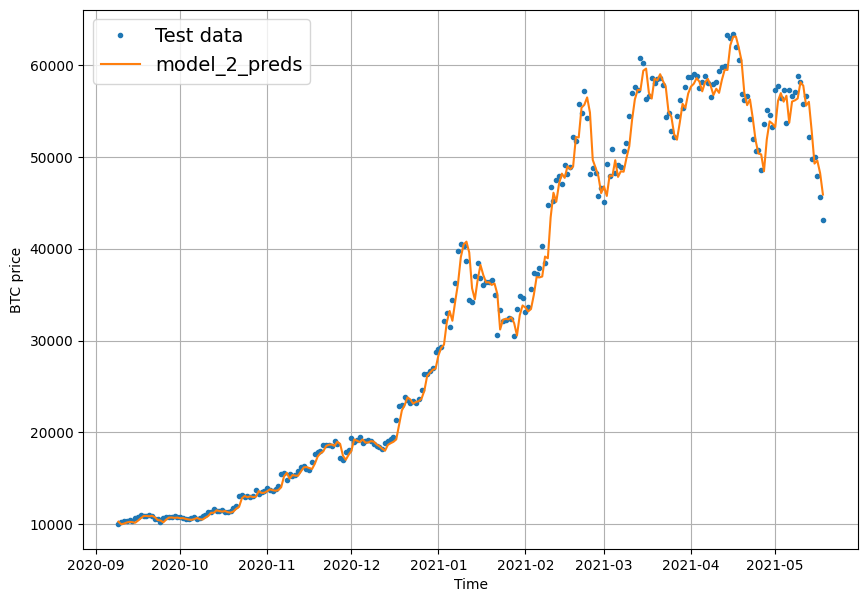

In [48]:
## Lets plot the predictions
offset=300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_window):],values=test_label[:,0]
                 ,start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_window):],values=model_2_preds
                 ,start=offset,label="model_2_preds",format="-")

## Model 3: Window size=30, Horizon=7

In [49]:
WINDOW_SIZE=30
HORIZON=7
full_window, full_label = make_windows(prices, window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_window), len(full_label)

(2751, 2751)

In [50]:
train_window, train_label, test_window, test_label = make_train_test_split(windows=full_window, labels=full_label
                                                                           ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)

(2200, 2200, 551, 551)

In [52]:
import tensorflow as tf
from tensorflow.keras import layers
# set random seed
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_3_dense")

model_3.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"])

history_3 = model_3.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
53/69 [======================>.......] - ETA: 0s - loss: 996.0812 - mae: 996.0812  

69/69 [==============================] - 2s 19ms/step - loss: 846.7227 - mae: 846.7227 - val_loss: 2043.8990 - val_mae: 2043.8990
Epoch 2/100
56/69 [=======================>......] - ETA: 0s - loss: 349.8964 - mae: 349.8964

69/69 [==============================] - 1s 11ms/step - loss: 352.3566 - mae: 352.3566 - val_loss: 1565.6602 - val_mae: 1565.6602
Epoch 3/100
69/69 [==============================] - 0s 3ms/step - loss: 300.3606 - mae: 300.3606 - val_loss: 1608.9672 - val_mae: 1608.9672
Epoch 4/100
55/69 [======================>.......] - ETA: 0s - loss: 291.1359 - mae: 291.1359

69/69 [==============================] - 1s 11ms/step - loss: 284.9975 - mae: 284.9975 - val_loss: 1489.1354 - val_mae: 1489.1354
Epoch 5/100
69/69 [==============================] - 0s 3ms/step - loss: 278.6910 - mae: 278.6910 - val_loss: 1757.2657 - val_mae: 1757.2657
Epoch 6/100
69/69 [==============================] - 0s 3ms/step - loss: 271.9468 - mae: 271.9468 - val_loss: 1579.1057 - val_mae: 1579.1057
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 277.4727 - mae: 277.4727 - val_loss: 1572.6655 - val_mae: 1572.6655
Epoch 8/100
69/69 [==============================] - 0s 3ms/step - loss: 278.7933 - mae: 278.7933 - val_loss: 1500.2639 - val_mae: 1500.2639
Epoch 9/100
54/69 [======================>.......] - ETA: 0s - loss: 261.8006 - mae: 261.8006

69/69 [==============================] - 1s 11ms/step - loss: 262.2870 - mae: 262.2870 - val_loss: 1438.7798 - val_mae: 1438.7798
Epoch 10/100
69/69 [==============================] - 0s 3ms/step - loss: 265.2471 - mae: 265.2471 - val_loss: 1503.5905 - val_mae: 1503.5905
Epoch 11/100
60/69 [=========================>....] - ETA: 0s - loss: 259.2946 - mae: 259.2946

69/69 [==============================] - 1s 11ms/step - loss: 255.4792 - mae: 255.4792 - val_loss: 1421.5713 - val_mae: 1421.5713
Epoch 12/100
69/69 [==============================] - 0s 4ms/step - loss: 255.3026 - mae: 255.3026 - val_loss: 1539.1226 - val_mae: 1539.1226
Epoch 13/100
69/69 [==============================] - 0s 3ms/step - loss: 258.6496 - mae: 258.6496 - val_loss: 1762.1650 - val_mae: 1762.1650
Epoch 14/100
58/69 [========================>.....] - ETA: 0s - loss: 245.7372 - mae: 245.7372

69/69 [==============================] - 1s 11ms/step - loss: 253.1696 - mae: 253.1696 - val_loss: 1407.9760 - val_mae: 1407.9760
Epoch 15/100
69/69 [==============================] - 0s 3ms/step - loss: 250.0530 - mae: 250.0530 - val_loss: 1483.4685 - val_mae: 1483.4685
Epoch 16/100
69/69 [==============================] - 0s 3ms/step - loss: 256.6672 - mae: 256.6672 - val_loss: 1460.6094 - val_mae: 1460.6094
Epoch 17/100
69/69 [==============================] - 0s 3ms/step - loss: 250.4727 - mae: 250.4727 - val_loss: 1542.8229 - val_mae: 1542.8229
Epoch 18/100
69/69 [==============================] - 0s 3ms/step - loss: 245.7775 - mae: 245.7775 - val_loss: 1423.8270 - val_mae: 1423.8270
Epoch 19/100
49/69 [====================>.........] - ETA: 0s - loss: 245.7557 - mae: 245.7557

69/69 [==============================] - 1s 11ms/step - loss: 251.9538 - mae: 251.9538 - val_loss: 1385.0708 - val_mae: 1385.0708
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 255.3189 - mae: 255.3189 - val_loss: 1430.8977 - val_mae: 1430.8977
Epoch 21/100
54/69 [======================>.......] - ETA: 0s - loss: 246.0606 - mae: 246.0606

69/69 [==============================] - 1s 11ms/step - loss: 243.3049 - mae: 243.3049 - val_loss: 1343.5448 - val_mae: 1343.5448
Epoch 22/100
69/69 [==============================] - 0s 3ms/step - loss: 243.2152 - mae: 243.2152 - val_loss: 1607.6814 - val_mae: 1607.6814
Epoch 23/100
53/69 [======================>.......] - ETA: 0s - loss: 252.1990 - mae: 252.1990

69/69 [==============================] - 1s 11ms/step - loss: 249.0037 - mae: 249.0037 - val_loss: 1305.0360 - val_mae: 1305.0360
Epoch 24/100
69/69 [==============================] - 0s 3ms/step - loss: 246.1568 - mae: 246.1568 - val_loss: 1434.2681 - val_mae: 1434.2681
Epoch 25/100
69/69 [==============================] - 0s 3ms/step - loss: 243.2141 - mae: 243.2141 - val_loss: 1497.4182 - val_mae: 1497.4182
Epoch 26/100
69/69 [==============================] - 0s 3ms/step - loss: 241.9401 - mae: 241.9401 - val_loss: 1417.7046 - val_mae: 1417.7046
Epoch 27/100
69/69 [==============================] - 0s 3ms/step - loss: 244.0023 - mae: 244.0023 - val_loss: 1321.3407 - val_mae: 1321.3407
Epoch 28/100
69/69 [==============================] - 0s 4ms/step - loss: 242.7293 - mae: 242.7293 - val_loss: 1318.2595 - val_mae: 1318.2595
Epoch 29/100
55/69 [======================>.......] - ETA: 0s - loss: 231.8188 - mae: 231.8188

69/69 [==============================] - 1s 16ms/step - loss: 236.0470 - mae: 236.0470 - val_loss: 1300.7709 - val_mae: 1300.7709
Epoch 30/100
69/69 [==============================] - 0s 4ms/step - loss: 236.4514 - mae: 236.4514 - val_loss: 1543.2531 - val_mae: 1543.2531
Epoch 31/100
69/69 [==============================] - 0s 4ms/step - loss: 240.4004 - mae: 240.4004 - val_loss: 1367.2736 - val_mae: 1367.2736
Epoch 32/100
61/69 [=========================>....] - ETA: 0s - loss: 245.7378 - mae: 245.7378

69/69 [==============================] - 1s 14ms/step - loss: 245.9132 - mae: 245.9132 - val_loss: 1299.9855 - val_mae: 1299.9855
Epoch 33/100
58/69 [========================>.....] - ETA: 0s - loss: 239.3669 - mae: 239.3669

69/69 [==============================] - 1s 11ms/step - loss: 238.5193 - mae: 238.5193 - val_loss: 1283.5826 - val_mae: 1283.5826
Epoch 34/100
69/69 [==============================] - 0s 3ms/step - loss: 236.9026 - mae: 236.9026 - val_loss: 1544.0841 - val_mae: 1544.0841
Epoch 35/100
69/69 [==============================] - 0s 3ms/step - loss: 233.7392 - mae: 233.7392 - val_loss: 1296.3256 - val_mae: 1296.3256
Epoch 36/100
57/69 [=======================>......] - ETA: 0s - loss: 242.0732 - mae: 242.0732

69/69 [==============================] - 1s 11ms/step - loss: 242.8739 - mae: 242.8739 - val_loss: 1277.9849 - val_mae: 1277.9849
Epoch 37/100
59/69 [========================>.....] - ETA: 0s - loss: 235.4227 - mae: 235.4227

69/69 [==============================] - 1s 11ms/step - loss: 237.5161 - mae: 237.5161 - val_loss: 1266.6346 - val_mae: 1266.6346
Epoch 38/100
69/69 [==============================] - 0s 3ms/step - loss: 230.9580 - mae: 230.9580 - val_loss: 1326.9849 - val_mae: 1326.9849
Epoch 39/100
69/69 [==============================] - 0s 3ms/step - loss: 246.4270 - mae: 246.4270 - val_loss: 1269.1321 - val_mae: 1269.1321
Epoch 40/100
69/69 [==============================] - 0s 3ms/step - loss: 238.7650 - mae: 238.7650 - val_loss: 1312.5228 - val_mae: 1312.5228
Epoch 41/100
69/69 [==============================] - 0s 3ms/step - loss: 232.3320 - mae: 232.3320 - val_loss: 1276.6072 - val_mae: 1276.6072
Epoch 42/100
69/69 [==============================] - 0s 3ms/step - loss: 238.2498 - mae: 238.2498 - val_loss: 1714.3173 - val_mae: 1714.3173
Epoch 43/100
55/69 [======================>.......] - ETA: 0s - loss: 252.3806 - mae: 252.3806

69/69 [==============================] - 1s 16ms/step - loss: 248.2959 - mae: 248.2959 - val_loss: 1244.9137 - val_mae: 1244.9137
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 234.0295 - mae: 234.0295 - val_loss: 1679.3494 - val_mae: 1679.3494
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 238.2320 - mae: 238.2320 - val_loss: 1319.0879 - val_mae: 1319.0879
Epoch 46/100
69/69 [==============================] - 0s 3ms/step - loss: 237.4849 - mae: 237.4849 - val_loss: 1358.8652 - val_mae: 1358.8652
Epoch 47/100
69/69 [==============================] - 0s 3ms/step - loss: 240.5072 - mae: 240.5072 - val_loss: 1734.9786 - val_mae: 1734.9786
Epoch 48/100
69/69 [==============================] - 0s 3ms/step - loss: 239.5620 - mae: 239.5620 - val_loss: 1298.0153 - val_mae: 1298.0153
Epoch 49/100
69/69 [==============================] - 0s 3ms/step - loss: 225.4854 - mae: 225.4854 - val_loss: 1258.0249 - val_mae: 1258.0249
Epoch 50/100
69/69

69/69 [==============================] - 1s 12ms/step - loss: 230.8013 - mae: 230.8013 - val_loss: 1243.8326 - val_mae: 1243.8326
Epoch 58/100
58/69 [========================>.....] - ETA: 0s - loss: 231.0643 - mae: 231.0643

69/69 [==============================] - 1s 11ms/step - loss: 232.5448 - mae: 232.5448 - val_loss: 1236.9351 - val_mae: 1236.9351
Epoch 59/100
69/69 [==============================] - 0s 3ms/step - loss: 230.2398 - mae: 230.2398 - val_loss: 1279.8062 - val_mae: 1279.8062
Epoch 60/100
69/69 [==============================] - 0s 3ms/step - loss: 233.5836 - mae: 233.5836 - val_loss: 1302.7483 - val_mae: 1302.7483
Epoch 61/100
69/69 [==============================] - 0s 3ms/step - loss: 226.0904 - mae: 226.0904 - val_loss: 1357.9009 - val_mae: 1357.9009
Epoch 62/100
69/69 [==============================] - 0s 4ms/step - loss: 228.9471 - mae: 228.9471 - val_loss: 1416.8037 - val_mae: 1416.8037
Epoch 63/100
69/69 [==============================] - 1s 8ms/step - loss: 227.8373 - mae: 227.8373 - val_loss: 1489.9729 - val_mae: 1489.9729
Epoch 64/100
69/69 [==============================] - 2s 23ms/step - loss: 226.8803 - mae: 226.8803 - val_loss: 1243.9075 - val_mae: 1243.9075
Epoch 65/100
69/6

69/69 [==============================] - 1s 11ms/step - loss: 225.5310 - mae: 225.5310 - val_loss: 1225.6266 - val_mae: 1225.6266
Epoch 74/100
69/69 [==============================] - 0s 3ms/step - loss: 224.5132 - mae: 224.5132 - val_loss: 1566.0409 - val_mae: 1566.0409
Epoch 75/100
69/69 [==============================] - 0s 3ms/step - loss: 225.8949 - mae: 225.8949 - val_loss: 1348.7499 - val_mae: 1348.7499
Epoch 76/100
69/69 [==============================] - 0s 3ms/step - loss: 225.8007 - mae: 225.8007 - val_loss: 1301.1759 - val_mae: 1301.1759
Epoch 77/100
69/69 [==============================] - 0s 3ms/step - loss: 227.2255 - mae: 227.2255 - val_loss: 1234.2107 - val_mae: 1234.2107
Epoch 78/100
69/69 [==============================] - 0s 3ms/step - loss: 228.1545 - mae: 228.1545 - val_loss: 1388.4773 - val_mae: 1388.4773
Epoch 79/100
69/69 [==============================] - 0s 3ms/step - loss: 221.5804 - mae: 221.5804 - val_loss: 1237.7065 - val_mae: 1237.7065
Epoch 80/100
69/69

69/69 [==============================] - 1s 11ms/step - loss: 230.4504 - mae: 230.4504 - val_loss: 1210.0454 - val_mae: 1210.0454
Epoch 86/100
69/69 [==============================] - 0s 4ms/step - loss: 225.8407 - mae: 225.8407 - val_loss: 1289.8534 - val_mae: 1289.8534
Epoch 87/100
69/69 [==============================] - 0s 3ms/step - loss: 230.1941 - mae: 230.1941 - val_loss: 1253.6757 - val_mae: 1253.6757
Epoch 88/100
69/69 [==============================] - 0s 3ms/step - loss: 230.9439 - mae: 230.9439 - val_loss: 1652.9177 - val_mae: 1652.9177
Epoch 89/100
69/69 [==============================] - 0s 3ms/step - loss: 229.6037 - mae: 229.6037 - val_loss: 1279.8501 - val_mae: 1279.8501
Epoch 90/100
69/69 [==============================] - 0s 3ms/step - loss: 224.9014 - mae: 224.9014 - val_loss: 1227.6605 - val_mae: 1227.6605
Epoch 91/100
69/69 [==============================] - 0s 3ms/step - loss: 232.5559 - mae: 232.5559 - val_loss: 1324.2573 - val_mae: 1324.2573
Epoch 92/100
52/69

69/69 [==============================] - 1s 11ms/step - loss: 220.6001 - mae: 220.6001 - val_loss: 1206.6467 - val_mae: 1206.6467
Epoch 93/100
69/69 [==============================] - 0s 3ms/step - loss: 231.9457 - mae: 231.9457 - val_loss: 1809.3190 - val_mae: 1809.3190
Epoch 94/100
69/69 [==============================] - 0s 3ms/step - loss: 245.2350 - mae: 245.2350 - val_loss: 1334.7628 - val_mae: 1334.7628
Epoch 95/100
69/69 [==============================] - 0s 3ms/step - loss: 224.4996 - mae: 224.4996 - val_loss: 1220.6638 - val_mae: 1220.6638
Epoch 96/100
69/69 [==============================] - 0s 3ms/step - loss: 219.0685 - mae: 219.0685 - val_loss: 1241.0936 - val_mae: 1241.0936
Epoch 97/100
69/69 [==============================] - 0s 3ms/step - loss: 217.5887 - mae: 217.5887 - val_loss: 1253.1259 - val_mae: 1253.1259
Epoch 98/100
50/69 [====================>.........] - ETA: 0s - loss: 209.4306 - mae: 209.4306

69/69 [==============================] - 1s 12ms/step - loss: 220.3041 - mae: 220.3041 - val_loss: 1206.1910 - val_mae: 1206.1910
Epoch 99/100
69/69 [==============================] - 0s 3ms/step - loss: 218.1505 - mae: 218.1505 - val_loss: 1247.2559 - val_mae: 1247.2559
Epoch 100/100
69/69 [==============================] - 0s 4ms/step - loss: 220.5492 - mae: 220.5492 - val_loss: 1381.8356 - val_mae: 1381.8356


In [53]:
model_3.evaluate(test_window,test_label)

18/18 [==============================] - 0s 5ms/step - loss: 1381.8356 - mae: 1381.8356


[1381.8355712890625, 1381.8355712890625]

In [54]:
model_3_preds = make_preds(model_3,test_window)
len(model_3_preds), model_3_preds[:10]

18/18 [==============================] - 0s 3ms/step


(551,
 <tf.Tensor: shape=(10, 7), dtype=float32, numpy=
 array([[9001.117 , 9063.797 , 9028.774 , 9219.079 , 9090.499 , 9068.122 ,
         9113.46  ],
        [8569.566 , 8682.135 , 8675.305 , 8807.097 , 8776.571 , 8848.901 ,
         8771.477 ],
        [8450.903 , 8530.959 , 8541.506 , 8726.513 , 8796.529 , 8734.108 ,
         8685.588 ],
        [8602.307 , 8777.918 , 8722.334 , 8874.064 , 8996.796 , 8907.58  ,
         8865.221 ],
        [8434.203 , 8717.391 , 8622.649 , 8888.253 , 8810.348 , 8818.8   ,
         8696.077 ],
        [8554.482 , 8688.567 , 8691.994 , 8897.771 , 8845.446 , 8704.281 ,
         8648.812 ],
        [8534.882 , 8551.249 , 8734.171 , 8655.208 , 8660.762 , 8488.113 ,
         8503.91  ],
        [8399.624 , 8425.959 , 8569.174 , 8433.444 , 8438.163 , 8357.076 ,
         8273.242 ],
        [8214.906 , 8235.254 , 8269.183 , 8232.827 , 8285.837 , 8196.741 ,
         8096.4155],
        [8068.147 , 8133.4946, 8025.4526, 8223.87  , 8241.962 , 8058.047 ,
     

In [55]:
model_3_results = evaluate_pred(y_true=tf.squeeze(test_label),
                                y_pred=model_3_preds)
model_3_results

{'mae': array([ 305.30972 ,  171.39648 ,  234.65764 ,  233.2694  ,  270.5096  ,
         311.91428 ,  258.4456  ,  238.02881 ,  337.6363  ,  421.2295  ,
         552.6022  ,  595.2013  ,  646.3648  ,  629.7458  ,  258.70285 ,
         251.49129 ,  350.07895 ,  579.87537 ,  543.3854  ,  554.3476  ,
         218.51604 ,  230.97697 ,  159.8524  ,  141.74045 ,  184.82932 ,
         297.89502 ,  363.5422  ,  394.57486 ,  334.65396 ,  172.17717 ,
         118.556015,   94.191124,  138.93137 ,  212.85066 ,  257.50092 ,
         270.55588 ,  173.29213 ,  240.48166 ,  283.9241  ,  471.3132  ,
         812.74475 ,  322.44986 ,  274.38232 ,  248.83572 ,  134.70871 ,
         218.70842 ,  223.92049 ,  248.2761  ,  247.0867  ,  265.06348 ,
         270.76822 ,  236.90688 ,  141.35889 ,  275.4184  ,  427.44022 ,
         560.9137  ,  883.662   ,  770.91425 ,  740.626   ,  797.6432  ,
         618.89844 ,  410.50006 ,  396.07053 ,  693.9232  ,  699.4189  ,
         744.81195 ,  794.4498  ,  814.45496